# Overview

This notebook contains the cells responsible for training the autoencoder/CNN model called CsiNet, which is used for CSI compression. The original code is at https://github.com/sydney222/Python_CsiNet and the corresponding paper is:
C. -K. Wen, W. -T. Shih and S. Jin, "Deep Learning for Massive MIMO CSI Feedback," in IEEE Wireless Communications Letters, vol. 7, no. 5, pp. 748-751, Oct. 2018, doi: 10.1109/LWC.2018.2818160.

In [15]:
# Import necessary modules
import math
import time
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
tf.compat.v1.reset_default_graph()

In [16]:
# Set image and network params
#envir = 'indoor' #'indoor' or 'outdoor'

# Image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels

# Network params
residual_num = 1 #original value = 2
#compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32
encoded_dim = 32 #original value = 512

In [17]:
# Build the autoencoder model (CNN model) of CsiNet
def residual_network(x, residual_num, encoded_dim):
  def add_common_layers(y):
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    
    return y
  
  def residual_block_decoded(y):
    shortcut = y
    y = Conv2D(8, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
    y = add_common_layers(y)
    
    y = Conv2D(16, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
    y = add_common_layers(y)
    
    y = Conv2D(2, kernel_size=(3, 3), padding='same', data_format='channels_first')(y)
    y = BatchNormalization()(y)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y
  
  x = Conv2D(2, (3, 3), padding='same', data_format="channels_first")(x)
  x = add_common_layers(x)
  
  x = Reshape((img_total,))(x)
  encoded = Dense(encoded_dim, activation='linear')(x)
  
  x = Dense(img_total, activation='linear')(encoded)
  x = Reshape((img_channels, img_height, img_width,))(x)
  for i in range(residual_num):
    x = residual_block_decoded(x)
  
  x = Conv2D(2, (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)
  
  return x

In [18]:
# Set autoencoder model params and display the network model
image_tensor = Input(shape=(img_channels, img_height, img_width))
network_output = residual_network(image_tensor, residual_num, encoded_dim)
autoencoder = Model(inputs=[image_tensor], outputs=[network_output])
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 32, 32)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 2, 32, 32)    38          ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 32, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2, 32, 32)    0           ['batch_normalization[0][0]']

In [19]:
# Load dataset
mat = sio.loadmat('files_06_channel/data/DATA_Htrainin_10k.mat') 
x_train = mat['HT'] # array
mat = sio.loadmat('files_06_channel/data/DATA_Hvalin_3k.mat')
x_val = mat['HT'] # array
mat = sio.loadmat('files_06_channel/data/DATA_Htestin_2k.mat')
x_test = mat['HT'] # array

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train = np.reshape(x_train, (len(x_train), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

In [20]:
# Create a class to save the loss history of the model
class LossHistory(Callback):
  def on_train_begin(self, logs={}):
    self.losses_train = []
    self.losses_val = []
  
  def on_batch_end(self, batch, logs={}):
    self.losses_train.append(logs.get('loss'))    
    
  def on_epoch_end(self, epoch, logs={}):
    self.losses_val.append(logs.get('val_loss'))

history = LossHistory()
file = 'CsiNet_indoor_dim'+str(encoded_dim)+time.strftime('_%m_%d')
path = 'files_06_channel/result/TensorBoard_%s' %file

In [21]:
# Train the model with the specified params and save the train loss and val loss in a csv file
autoencoder.fit(x_train, x_train,
                epochs=10, #original value = 1000
                batch_size=20, #original value = 200
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[history,
                           TensorBoard(log_dir = path)])

filename = 'files_06_channel/result/trainloss_%s.csv'%file
loss_history = np.array(history.losses_train)
np.savetxt(filename, loss_history, delimiter=",")

filename = 'files_06_channel/result/valloss_%s.csv'%file
loss_history = np.array(history.losses_val)
np.savetxt(filename, loss_history, delimiter=",")

Epoch 1/10
500/500 [==============================] - 7s 12ms/step - loss: 0.0011 - val_loss: 4.6629e-04
Epoch 2/10
500/500 [==============================] - 5s 11ms/step - loss: 4.5858e-04 - val_loss: 4.5632e-04
Epoch 3/10
500/500 [==============================] - 5s 10ms/step - loss: 4.5243e-04 - val_loss: 4.5382e-04
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 4.4241e-04 - val_loss: 4.3799e-04
Epoch 5/10
500/500 [==============================] - 5s 10ms/step - loss: 4.1947e-04 - val_loss: 4.0396e-04
Epoch 6/10
500/500 [==============================] - 5s 9ms/step - loss: 3.8956e-04 - val_loss: 3.7409e-04
Epoch 7/10
500/500 [==============================] - 5s 9ms/step - loss: 3.6135e-04 - val_loss: 3.4944e-04
Epoch 8/10
500/500 [==============================] - 5s 9ms/step - loss: 3.3854e-04 - val_loss: 3.2877e-04
Epoch 9/10
500/500 [==============================] - 5s 10ms/step - loss: 3.2162e-04 - val_loss: 3.1511e-04
Epoch 10/10
500/500 [=====

In [22]:
# Testing data
tStart = time.time()
x_hat = autoencoder.predict(x_test)
tEnd = time.time()
print ("It cost %f sec" % ((tEnd - tStart)/x_test.shape[0]))

63/63 [==============================] - 0s 5ms/step
It cost 0.000251 sec


In [23]:
# Calculating the NMSE and rho
mat = sio.loadmat('files_06_channel/data/DATA_HtestFin_all_2k.mat')
X_test = mat['HF_all']# array

X_test = np.reshape(X_test, (len(X_test), img_height, 125))
x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)
x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = np.real(n1) #cast to real given that the imaginary part is zero
n1 = n1.astype('float64')

n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = np.real(n2) #cast to real given that the imaginary part is zero
n2 = n2.astype('float64')

aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

In [24]:
print("In indoor environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))

filename = "files_06_channel/result/decoded_%s.csv"%file
x_hat1 = np.reshape(x_hat, (len(x_hat), -1))
np.savetxt(filename, x_hat1, delimiter=",")
filename = "files_06_channel/result/rho_%s.csv"%file
np.savetxt(filename, rho, delimiter=",")

In indoor environment
When dimension is 32
NMSE is  -1.8142097843701201
Correlation is  0.6377203692447541


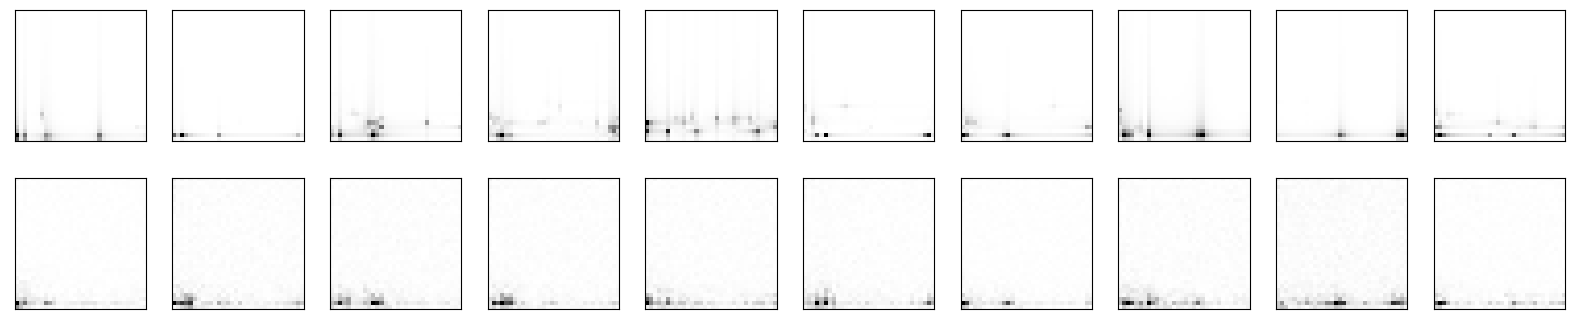

In [25]:
# Display the original and reconstructed pseudo-gray plots of the magnitude of channel H
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1 )
  x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()
  
  # display reconstructed
  ax = plt.subplot(2, n, i + 1 + n)
  decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5
                        + 1j*(x_hat[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()

plt.show()

In [26]:
# Save the autoencoder model as JSON and the weights as HDF5 
model_json = autoencoder.to_json()
outfile = "files_06_channel/result/sbrt_model_%s.json"%file
with open(outfile, "w") as json_file:
  json_file.write(model_json)
outfile = "files_06_channel/result/sbrt_model_%s.h5"%file
autoencoder.save_weights(outfile)